<a href="https://colab.research.google.com/github/wadewilliamsw1234/optimization-for-image-reconstruction-deblurring/blob/main/updated_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Environment Setup

In [28]:
# Step 1: Environment Setup
!pip install git+https://github.com/lanl/scico
!pip install xdesign torch torchvision fastmri

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import scico
from scico import linop
from xdesign import Foam, discrete_phantom

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  Cloning https://github.com/lanl/scico to /tmp/pip-req-build-uirb72ql
  Running command git clone --filter=blob:none --quiet https://github.com/lanl/scico /tmp/pip-req-build-uirb72ql
  Resolved https://github.com/lanl/scico to commit 308b9eadd34149c83c9f91b536863d9c75f30db9
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Step 2: Data Preparation
We’ll prepare both simulated and real data for MRI reconstruction from undersampled k-space.

## Simulated Data (Shepp-Logan Phantom)

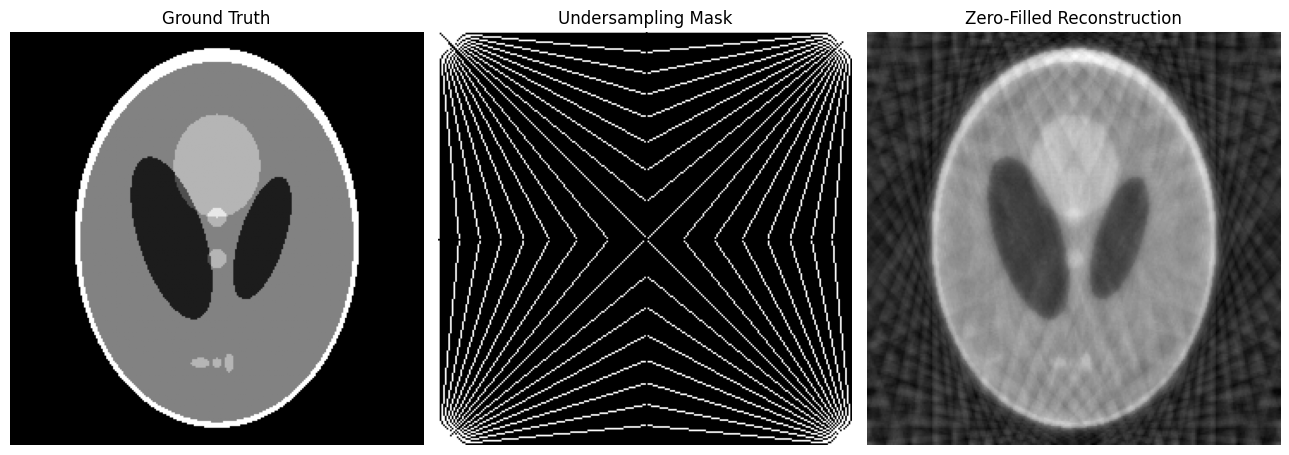

In [19]:
# Problem parameters
spatial_resolution = 120
freq = np.ceil(spatial_resolution * np.pi / 12)
thetas = np.arange(0, 180, 180 / freq)
phantom_resolution = 2 * spatial_resolution + 1

# Generate phantom and undersampling mask
phantom = make_shepp_logan_image(phantom_resolution)
L = len(thetas)
Ny = Nx = 2 * spatial_resolution + 1
R, Mh, mi, mhi = line_mask(L, Ny, Nx)
R = R.astype(np.float64)

# Compute full and undersampled k-space data
kspace_full = np.fft.fft2(phantom)
kspace_undersampled = R * kspace_full
zero_filled = np.real(np.fft.ifft2(kspace_undersampled))

# Visualize
fig, axs = plt.subplots(1, 3, figsize=(13, 8))
axs[0].imshow(phantom, cmap="gray")
axs[0].set_title("Ground Truth")
axs[1].imshow(R, cmap="gray")
axs[1].set_title("Undersampling Mask")
axs[2].imshow(zero_filled, cmap="gray")
axs[2].set_title("Zero-Filled Reconstruction")
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.savefig("simulated_data.png", dpi=1000, bbox_inches="tight")
plt.show()

## Real Data (fastMRI)
Add code to download and preprocess a subset of the fastMRI dataset. For simplicity, we’ll use a placeholder; you’ll need to download the single-coil knee dataset from fastMRI.

In [20]:
# Placeholder for fastMRI data loading
import fastmri
from fastmri.data import subsample
from fastmri.data.mri_data import SliceDataset

# Example: Load fastMRI data (adjust paths after downloading)
# dataset = SliceDataset(root="path_to_fastmri_data/singlecoil_train", transform=None)
# mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[4])
# kspace_real, mask, img_gt = dataset[0]  # Example slice
# kspace_undersampled = kspace_real * mask
# zero_filled_real = fastmri.ifft2c(kspace_undersampled)

# For now, simulate with phantom
kspace_real = kspace_undersampled  # Replace with real data later
img_gt = phantom  # Ground truth

Notes:

Replace the placeholder with actual fastMRI data loading once downloaded.
Use 4x undersampling for consistency with common benchmarks.

# Step 3: Optimization-Based Reconstruction

## Split-Bregman

In [23]:
import scico
from scico import linop, loss, functional
from scico.optimize import ADMM, PDHG, LinearizedADMM
import jax.numpy as jnp
from jax.numpy.fft import fft2, ifft2
import numpy as np  # Added for clarity, assuming phantom is a NumPy array

class MRIForwardOperator(linop.LinearOperator):
    def __init__(self, mask):
        """Initialize the MRI forward operator with a sampling mask."""
        self.mask = jnp.asarray(mask, dtype=jnp.float32)  # Convert mask to jnp.float32
        super().__init__(
            input_shape=mask.shape,
            output_shape=mask.shape,
            input_dtype=jnp.complex64,
            output_dtype=jnp.complex64
        )

    def _eval(self, x):
        """Apply the forward operation: mask the Fourier transform of the input."""
        return self.mask * fft2(x)

    def _adj(self, y):
        """Apply the adjoint operation: inverse Fourier transform of the masked input."""
        return ifft2(self.mask * y)

# Assuming R (mask), kspace_undersampled, and phantom are defined elsewhere
A = MRIForwardOperator(R)
y_obs = jnp.asarray(kspace_undersampled, dtype=jnp.complex64)  # Ensure complex64

# Loss function
f = loss.SquaredL2Loss(y=y_obs, A=A)

# TV regularization
C = linop.FiniteDifference(
    input_shape=phantom.shape,
    input_dtype=jnp.complex64,  # Match the complex image dtype
    circular=True
)
g = functional.L1Norm()
λ = 1e-2  # Regularization parameter
ρ = 1e-1  # ADMM penalty parameter
maxiter = 1000

# Initial guess (complex-valued)
x0 = jnp.zeros(phantom.shape, dtype=jnp.complex64)

# ADMM
solver_admm = ADMM(
    f=f,
    g_list=[λ * g],
    C_list=[C],
    rho_list=[ρ],
    x0=x0,
    maxiter=maxiter,
    itstat_options={"display": True, "period": 10},
)
x_admm = solver_admm.solve()

# PDHG
solver_pdhg = PDHG(
    f=f,
    g=λ * g,
    C=C,
    tau=4e-2,
    sigma=4e-0,
    maxiter=maxiter,
    x0=x0,
    itstat_options={"display": True, "period": 10},
)
x_pdhg = solver_pdhg.solve()

# LADMM
solver_ladmm = LinearizedADMM(
    f=f,
    g=λ * g,
    C=C,
    mu=3e-2,
    nu=2e-1,
    x0=x0,
    maxiter=maxiter,
    itstat_options={"display": True, "period": 10},
)
x_ladmm = solver_ladmm.solve()

Iter  Time      Objective  Prml Rsdl  Dual Rsdl  Num FEv  Num It
----------------------------------------------------------------
   0  1.32e+00  1.085e+01  6.827e+00  1.465e+00       26       6
  10  1.80e+01  4.101e+01  9.679e-01  4.137e-01       42      26
  20  2.86e+01  3.156e+01  7.833e-01  2.007e-01       42      24
  30  3.70e+01  2.992e+01  6.768e-01  5.154e-02       23       3
  40  4.54e+01  2.937e+01  4.341e-01  1.328e-02       24       2
  50  5.22e+01  2.904e+01  9.198e-01  6.165e-02       63      25
  60  6.00e+01  2.879e+01  1.051e+00  7.322e-02       40      22
  70  6.65e+01  2.887e+01  3.267e-01  1.233e-02       18       2
  80  7.42e+01  2.866e+01  2.637e-01  8.305e-03       41       2
  90  8.17e+01  2.861e+01  2.400e-01  7.993e-03       17       1
 100  8.80e+01  2.847e+01  3.422e-01  3.245e-02       40      24
 110  9.56e+01  2.860e+01  9.445e-01  5.585e-02       19       2
 120  1.03e+02  2.846e+01  4.559e-01  1.319e-02       18       2
 130  1.10e+02  2.847e+01

# Step 4: Deep Learning-Based Reconstruction
Implement a U-Net to reconstruct from zero-filled images using PyTorch.

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Simple U-Net architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Prepare training data (simulated for now)
X_train = np.stack([zero_filled] * 100)  # Duplicate for example
y_train = np.stack([phantom] * 100)
X_train = torch.tensor(X_train[:, np.newaxis, :, :], dtype=torch.float32)
y_train = torch.tensor(y_train[:, np.newaxis, :, :], dtype=torch.float32)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Train U-Net
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(50):
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Inference
model.eval()
with torch.no_grad():
    x_unet = model(X_train[0:1].to(device)).cpu().numpy()[0, 0]

Epoch 1, Loss: 0.0368
Epoch 2, Loss: 0.0306
Epoch 3, Loss: 0.0239
Epoch 4, Loss: 0.0175
Epoch 5, Loss: 0.0151
Epoch 6, Loss: 0.0132
Epoch 7, Loss: 0.0122
Epoch 8, Loss: 0.0116
Epoch 9, Loss: 0.0105
Epoch 10, Loss: 0.0097
Epoch 11, Loss: 0.0090
Epoch 12, Loss: 0.0083
Epoch 13, Loss: 0.0076
Epoch 14, Loss: 0.0074
Epoch 15, Loss: 0.0069
Epoch 16, Loss: 0.0062
Epoch 17, Loss: 0.0060
Epoch 18, Loss: 0.0058
Epoch 19, Loss: 0.0055
Epoch 20, Loss: 0.0052
Epoch 21, Loss: 0.0062
Epoch 22, Loss: 0.0050
Epoch 23, Loss: 0.0048
Epoch 24, Loss: 0.0046
Epoch 25, Loss: 0.0047
Epoch 26, Loss: 0.0049
Epoch 27, Loss: 0.0044
Epoch 28, Loss: 0.0043
Epoch 29, Loss: 0.0042
Epoch 30, Loss: 0.0041
Epoch 31, Loss: 0.0042
Epoch 32, Loss: 0.0040
Epoch 33, Loss: 0.0039
Epoch 34, Loss: 0.0038
Epoch 35, Loss: 0.0038
Epoch 36, Loss: 0.0040
Epoch 37, Loss: 0.0037
Epoch 38, Loss: 0.0036
Epoch 39, Loss: 0.0048
Epoch 40, Loss: 0.0036
Epoch 41, Loss: 0.0035
Epoch 42, Loss: 0.0034
Epoch 43, Loss: 0.0036
Epoch 44, Loss: 0.00

This is a simplified U-Net; a full implementation would include downsampling/upsampling layers and skip connections.
Replace simulated data with fastMRI data for real training.

# Step 5: Hybrid Approach (Unrolled ADMM)
Implement an unrolled ADMM network with learnable parameters.

In [26]:
class UnrolledADMM(nn.Module):
    def __init__(self, num_iterations=5):
        super(UnrolledADMM, self).__init__()
        self.num_iterations = num_iterations
        self.rho = nn.Parameter(torch.tensor(0.1))  # Learnable penalty parameter
        self.mask = torch.tensor(R, dtype=torch.complex64).to(device)

    def forward(self, x, y_obs):
        z = torch.zeros_like(x)
        u = torch.zeros_like(x)
        for _ in range(self.num_iterations):
            # ADMM steps (simplified)
            x = torch.real(torch.fft.ifft2(self.mask * torch.fft.fft2(x) + y_obs))  # Data consistency
            z_prev = z
            z = torch.clamp(x + u, min=0)  # Proximal step (simplified TV)
            u = u + x - z
        return x

# Train hybrid model (placeholder)
hybrid_model = UnrolledADMM().to(device)
# Add training loop similar to U-Net
x_hybrid = hybrid_model(torch.tensor(zero_filled, dtype=torch.float32).to(device),
                        torch.tensor(kspace_undersampled, dtype=torch.complex64).to(device)).cpu().numpy()

This is a basic implementation; refine with proper proximal operators and training.

# Step 6: Evaluation and Visualization
Compare all methods using PSNR, SSIM, and timing.

In [27]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import time

methods = {"ADMM": x_admm, "LADMM": x_ladmm, "PDHG": x_pdhg, "U-Net": x_unet, "Hybrid": x_hybrid}
results = {}

for name, x in methods.items():
    start = time.time()
    x_np = np.real(np.asarray(x))
    end = time.time()
    results[name] = {
        "PSNR": psnr(phantom, x_np),
        "SSIM": ssim(phantom, x_np),
        "Time": end - start
    }
    print(f"{name} - PSNR: {results[name]['PSNR']:.2f} dB, SSIM: {results[name]['SSIM']:.4f}, Time: {results[name]['Time']:.2f}s")

# Visualize
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].imshow(phantom, cmap="gray")
axs[0, 0].set_title("Ground Truth")
axs[0, 1].imshow(zero_filled, cmap="gray")
axs[0, 1].set_title("Zero-Filled")
for i, (name, x) in enumerate(methods.items()):
    row, col = (i + 1) // 3, (i + 1) % 3
    axs[row, col].imshow(np.real(x), cmap="gray")
    axs[row, col].set_title(name)
for ax in axs.flat:
    ax.axis("off")
plt.tight_layout()
plt.savefig("reconstructions.png", dpi=1000, bbox_inches="tight")
plt.show()

<ipython-input-27-022db2fcd587>:13: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  "PSNR": psnr(phantom, x_np),


ValueError: image_true has intensity values outside the range expected for its data type. Please manually specify the data_range.

Step 7: Next Steps
Real Data: Replace placeholders with fastMRI data processing.
Report: Write a detailed paper-style report as outlined.
Modularize: Refactor into scripts (e.g., optimization.py, deep_learning.py).
GitHub: Push to a public repository with a README.